In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
from AmbientesMP import *
from random import choice
from busqueda import Nodo , nodo_hijo

mpl.rcParams['figure.dpi'] = 300

In [233]:
import tqdm

## BREAD FIRST SEARCH

In [2]:
def breadth_first_search(prob):
    
    node = Nodo(estado = prob.estado_inicial,
                madre  = None, 
                accion = None, 
                costo_camino = 0, 
                codigo = "origin")
    
    if prob.test_objetivo(node.estado):
        return node
    
    frontier = [node]
    explored = []  
    
        
    while len(frontier) > 0:
        node = frontier.pop(0)
        explored.append(node.codigo)
        
        for action in prob.acciones_aplicables(node.estado):
            child = nodo_hijo(prob, node, action)
            
            if prob.test_objetivo(child.estado):
                return child
            
            if len(child.codigo) > len(prob.w):
                continue
            
            if child.codigo not in explored:
                frontier.append(child)

            
    return False

## DEPTH LIMITED SEARCH

In [3]:
def get_codes(node: Nodo):
    
    if node.madre == None:
        return [node.codigo]
    
    return  [] + [node.codigo] + get_codes(node.madre)

In [4]:
def is_cycle(node: Nodo):
    
    return len( set(get_codes(node)) ) != len(get_codes(node))

In [5]:
def expand(problema, node):
    
    state = node.estado
    nodes = []
    
    for action in problema.acciones_aplicables(state):
        child = nodo_hijo(problema, node, action)
        nodes.append(child)
        
    return nodes

In [6]:
def depth_(node):
    
    if node.madre == None:
        return 0
    
    return 1 + depth_(node.madre) 

In [7]:
def depth_limited_search(prob, l):
    
    node = Nodo(estado = prob.estado_inicial,
                madre  = None,
                accion = None, 
                costo_camino = 0,
                codigo = 'origin')
    
    frontier  = [node]
    result = "falla"
    
    while len(frontier) > 0:
        
        node = frontier.pop()
        
        if prob.test_objetivo(node.estado):
            return node
        
        if depth_(node) >= l:
            continue
            #return "cutoff"
        
        elif not is_cycle(node):
            
            for child in expand(prob, node):
                frontier.append(child)
                
    return result

## BEST FIRST SEARCH

In [8]:
import numpy as np

class ListaPrioritaria():
    
    def __init__(self):
        self.diccionario = {}
        
    def __str__(self):
        cadena = '['
        inicial = True
        for costo in self.diccionario:
            elementos = self.diccionario[costo]
            for elemento in elementos:
                if inicial:
                    cadena += '(' + str(elemento) + ',' + str(costo) + ')'
                    inicial = False
                else:
                    cadena += ', (' + str(elemento) + ',' + str(costo) + ')'

        return cadena + ']'
    
    def push(self, elemento, costo):
        try:
            self.diccionario[costo].append(elemento)
        except:
            self.diccionario[costo] = [elemento]
            
    def pop(self):
        min_costo  = min(list(self.diccionario.keys()))
        candidatos = self.diccionario[min_costo]
        elemento   = candidatos.pop()
        
        if len(candidatos) == 0:
            del self.diccionario[min_costo]
        return elemento
    
    def is_empty(self):
        return len(self.diccionario) == 0

In [9]:
def expand(problema, node):
    
    state = node.estado
    nodes = []
    
    for action in problema.acciones_aplicables(state):
        child = nodo_hijo(problema, node, action)
        nodes.append(child)
        
    return nodes

In [10]:
def error_function(state: str, obj: str) -> int:
    
    """
        Input:
            state: String de la forma "aaSbb" o "aabb" por ejemplo.
            
        Output:
            nuestra loca euristica (int)
    """

    if len(obj) == len(state):
        char_distance = sum([ 1 for l1, l2 in zip(list(obj), list(state))  if l1 != l2])**2
    
    else:
        char_distance = len(obj)**2
        
    lenght_distance = ( (len(obj) - len(state))**2 )

    return lenght_distance + char_distance

In [11]:
def costs(action: tuple)-> int:
    
    """
        INPUT:
                action: tupla de la forma ('S', 'aSb'), por ejemplo.
                
        OUTPUT:
                costo de tomar la acción (dependerá de que tan largo 
                sea el string, y esto lo hacemos para incentivar
                que acabe rápido)
    """

    return len(action[0])

In [12]:
from types import MethodType

def best_first_search(problem, fun):
      
    state = problem.estado_inicial
    code  = problem.codigo(state)
    node  = Nodo(estado = state,
                 madre  = None,
                 accion = None, 
                 costo_camino = 0,
                 codigo = 'origin')
    
    # pongo primer elemento en la frontera
    frontier = ListaPrioritaria()
    frontier.push(elemento = node,
                  costo    = 0)
    
    #explored dict
    explored = {}
    explored[code] = 0
    
    while not frontier.is_empty():
        
        node = frontier.pop()
        
        if problem.test_objetivo(node.estado):
            return node
    
        for child in expand(problem, node):
                
            state = child.estado
            code  = problem.codigo(state)
            cost  = fun(problem.codigo(state), problem.w)
            #cost = fun(child.accion)
            
            if len(child.codigo) > len(problem.w):
                continue
            
            if (code not in explored.keys()) or (cost < explored[code]):
                frontier.push(child, cost)
                explored[code]  = cost
                
    return "falla"

## GREEDY SEARCH

In [13]:
def greedy_search(problema, f):
    
    state = problema.estado_inicial
    node  = Nodo(estado = state, 
                 madre  = None, 
                 accion = None,
                 costo_camino = 0, 
                 codigo = "orgin")
    
    cost = f(problema.codigo(state), problema.w)
    
    frontier = ListaPrioritaria()
    frontier.push(node, cost)
    
    code = problema.codigo(state)
    explored = [code]
    
    while not frontier.is_empty():
        node = frontier.pop()

        if problema.test_objetivo(node.estado):
            return node
        
        for child in expand(problema, node):

            state = child.estado
            code  = problema.codigo(state)
            
            if len(code) > len(problema.w):
                continue

            if code not in explored:
                cost  = f(problema.codigo(state), problema.w)
                frontier.push(child, cost)
                explored.append(code)
    
    return None

## PRUEBAS

In [14]:
%load_ext autoreload
%autoreload 2
from example_grammars import ExampleGrammars

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
e = ExampleGrammars()

grammar_n = 3
gramatica = e.get_grammar(grammar_num = grammar_n)

w = e.generate_word(grammar_num = grammar_n,
                    word_interval_len = (3, 15))
prob = Parser(gramatica, w)
print(w, len(w))

aaaaaaaaaaaaab 14


In [16]:
#ans = best_first_search(problem = prob, fun = error_function)
#ans

In [17]:
#ans = breadth_first_search(prob  = prob)
#ans

In [18]:
#ans = depth_limited_search(prob = prob, l = len(w)*1)
#ans

In [19]:
#ans = greedy_search(prob, error_function)
#ans

## GRÁFICAS

In [29]:
%load_ext autoreload
%autoreload 2
from example_grammars import ExampleGrammars
from tiempos import *
from random import sample
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
e = ExampleGrammars()

funs = [
        lambda x: best_first_search(x, error_function),
        lambda x: greedy_search(x, error_function),
        lambda x: depth_limited_search(x, len(x.w)),
        lambda x: breadth_first_search(x)
       ]

nombres = [
            'Best first search (lenght and char diff.)', 
            'Greedy search (lenght and char diff.)',
            'Depth limited search',
            'Breadth first search'
          ]

word_interval_len = (1, 10)
n_times = 10
args = []
chosen_grammars = []

for i in range(n_times):

    grammar_n = choice((1,2,3))
    
    grammar = e.get_grammar(grammar_num = grammar_n)
    w = e.generate_word(grammar_num = grammar_n,
                        word_interval_len = word_interval_len)
    
    chosen_grammars.append((grammar_n, w))
    args.append(Parser(grammar, w))


for grammar, ex in chosen_grammars:
    print("g: {0} || w: {1}".format(grammar, ex))



g: 1 || w: aaaaabbbbb
g: 3 || w: aaaaaaaab
g: 1 || w: aaabbb
g: 3 || w: aaaaab
g: 1 || w: aaaabbbb
g: 1 || w: aaabbb
g: 2 || w: 
g: 1 || w: aaabbb
g: 2 || w: ad
g: 1 || w: aaaaabbbbb


In [26]:
data = compara_funciones_sobreargumentos(funs=funs, args=args, nombres=nombres)

Comparando funciones:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 0:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 1:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 2:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 3:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 4:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 5:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 6:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 7:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 8:   0%|          | 0/4 [00:00<?, ?it/s]

Probando función seleccionada iter. 9:   0%|          | 0/4 [00:00<?, ?it/s]

              sum_sq     df         F    PR(>F)
C(Función)  0.002616    3.0  5.908629  0.000595
Residual    0.058440  396.0       NaN       NaN


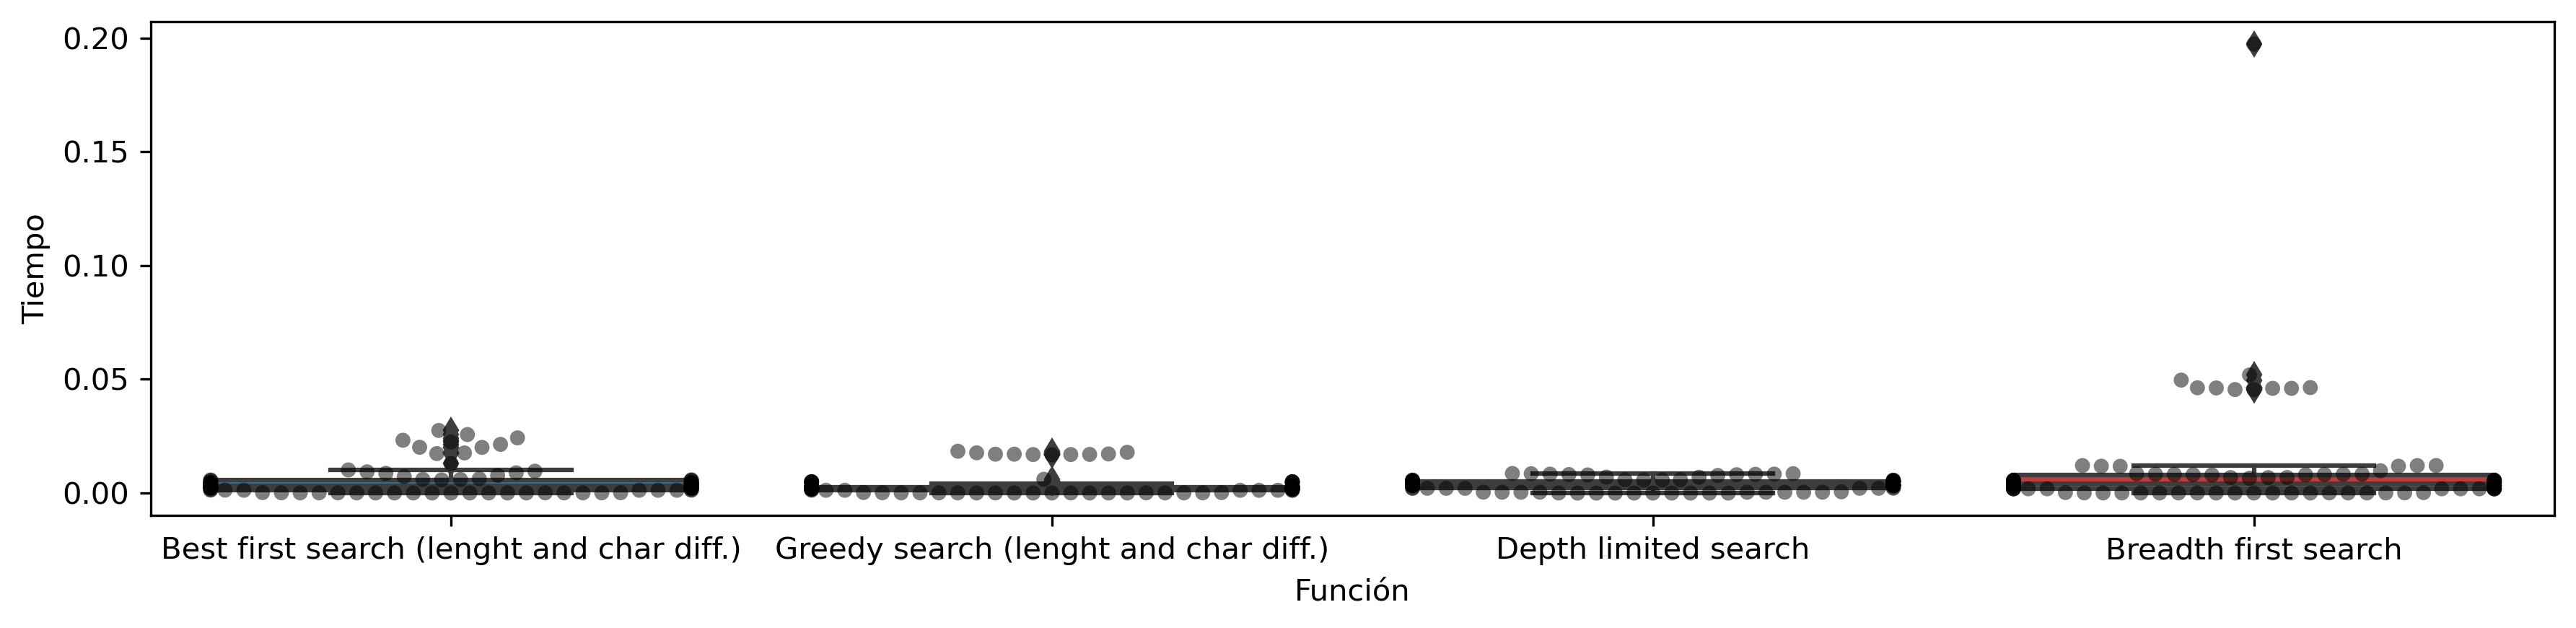

In [27]:
# Graficando
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data, x='Función', y='Tiempo')
sns.swarmplot(data=data, x='Función', y='Tiempo', color='black', alpha = 0.5, ax=ax);

# Anova diferencia de medias
model = ols('Tiempo ~ C(Función)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

              sum_sq     df         F    PR(>F)
C(Función)  0.002616    3.0  5.908629  0.000595
Residual    0.058440  396.0       NaN       NaN


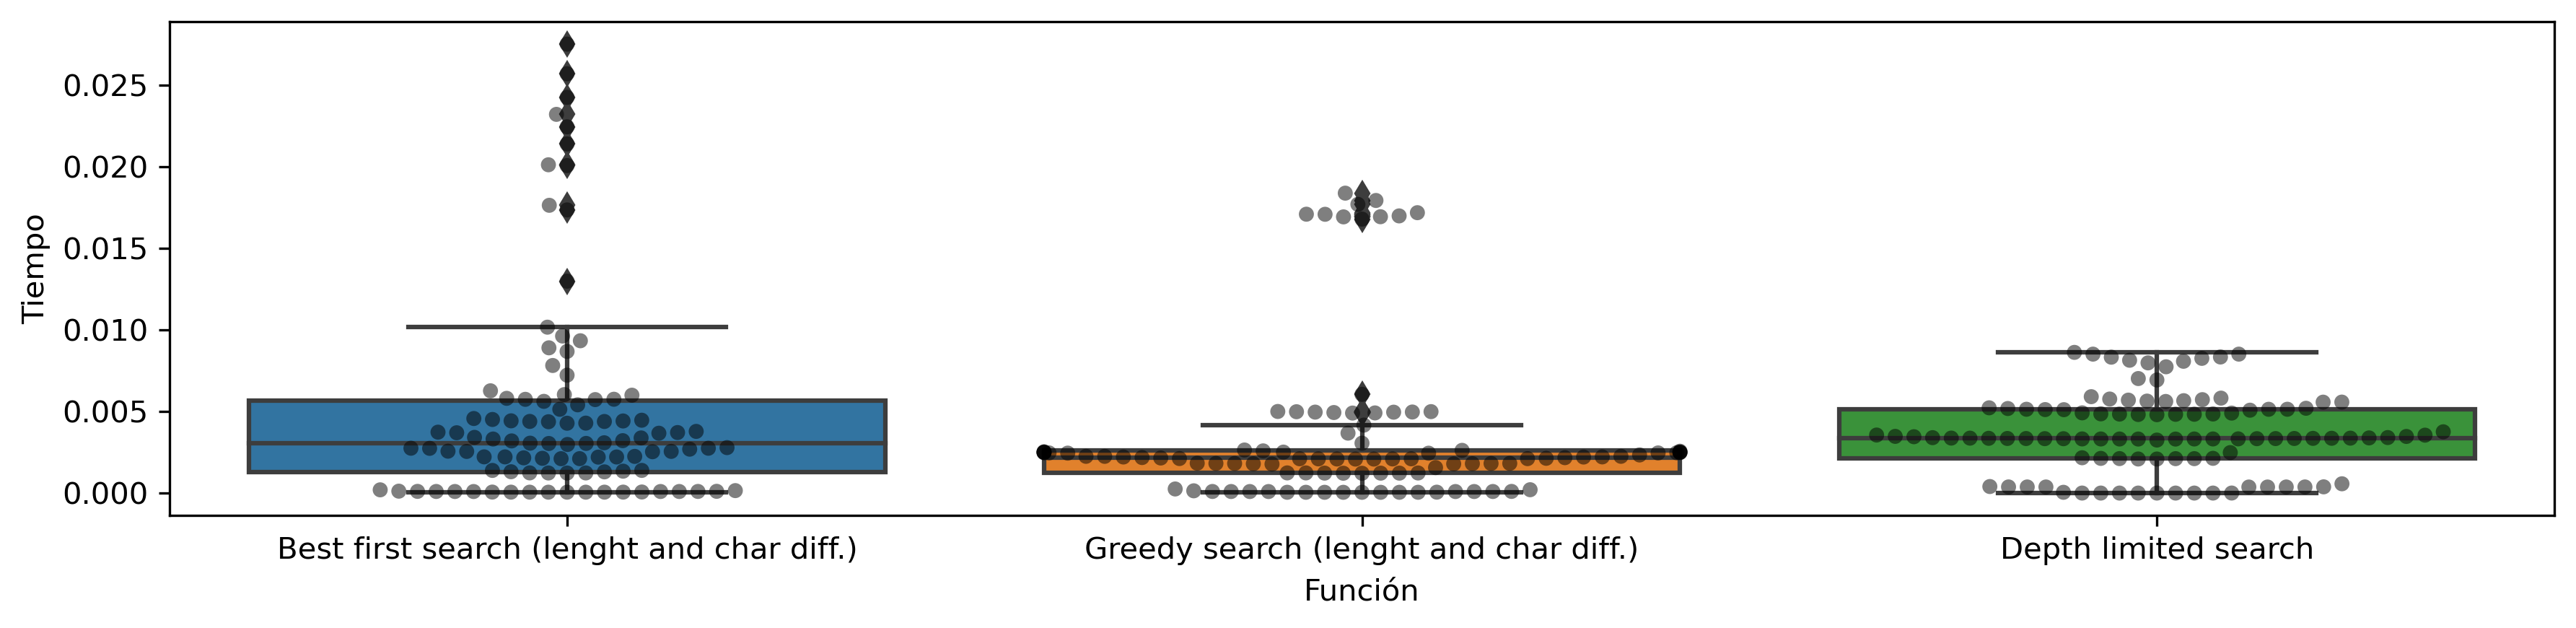

In [28]:
data2 = data[data["Función"] != 'Breadth first search']

# Graficando
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data2, x='Función', y='Tiempo')
sns.swarmplot(data=data2, x='Función', y='Tiempo', color='black', alpha = 0.5, ax=ax);

# Anova diferencia de medias
model = ols('Tiempo ~ C(Función)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

0.2929325945872764


'aaaaab'

In [235]:

max_len = 1000
times_exec = np.zeros(int(max_len/2))
ntries_given_size = 10


for i in tqdm.tqdm(range(0, max_len, 2), desc = "Calculando..."):
    
    choices = [choice((1,2,3)) for i in range(ntries_given_size)]
    words   = [e.generate_exact_word(grammar_num = choices[i], wlen = i) for i in range(ntries_given_size)]
    args    = [Parser(e.get_grammar(choices[i]), words[i]) for i in range(ntries_given_size)]
    
    times = 0
    
    for arg in args:
        times += np.mean(obtiene_tiempos(lambda x: greedy_search(x, error_function),
                                         args = (arg,),
                                         num_it = 500))
        
    times_exec[int(i/2)] = ( times/len(args) )
    

Calculando...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:02:26<00:00,  7.49s/it]


Text(0.5, 1.0, 'Análisis de tiempos de ejecución\nGreedy search\n(con heurística de diferencia en longitud y de caracteres)')

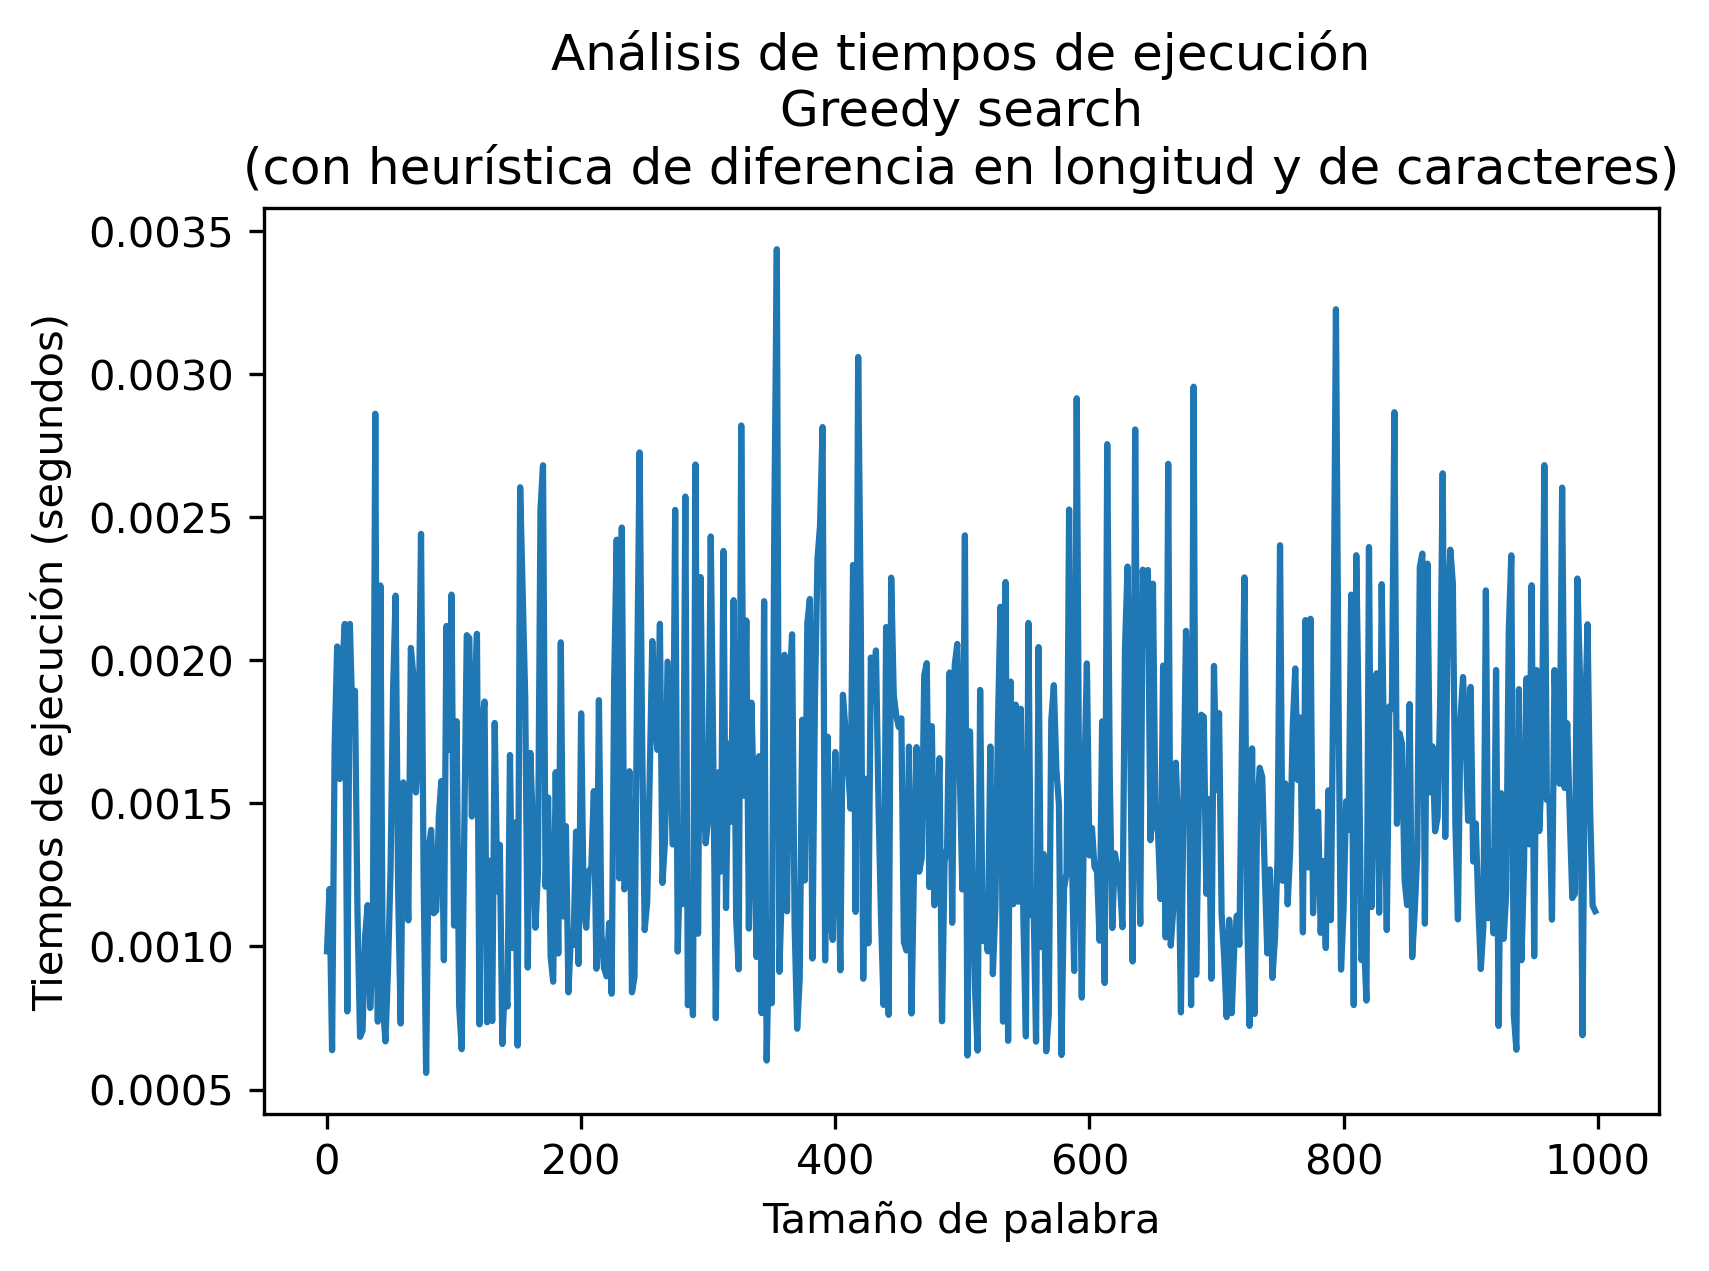

In [236]:
plt.plot(np.arange(0, max_len,2), times_exec)
plt.xlabel("Tamaño de palabra")
plt.ylabel("Tiempos de ejecución (segundos)")
plt.title("Análisis de tiempos de ejecución\nGreedy search\n(con heurística de diferencia en longitud y de caracteres)")